In [120]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import geoplot as gplot
import geoplot as gplt
import matplotlib as mpl
import gc

In [2]:
def process_date(d):
    m,d,y = d.split('/')
    if len(m) < 2:
        m = '0' + m
    if len(d) < 2:
        d = '0' + d
    return '/'.join([m,d,y])

In [3]:
def rename_cols(df,ind):
    dct = dict(zip(list(df.columns[ind:-1]), [process_date(x) for x in list(df.columns[ind:-1])]))
    df.rename(columns=dct,inplace=True)

In [4]:
# load covid data
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
conf = pd.read_csv(url + 'time_series_19-covid-Confirmed.csv')
dead = pd.read_csv(url + 'time_series_19-covid-Deaths.csv')
recs = pd.read_csv(url + 'time_series_19-covid-Recovered.csv')

In [5]:
conf.loc[conf['Province/State'].isna(), 'Province/State'] = 'none'
conf['geometry'] = gpd.points_from_xy(conf['Long'], conf['Lat'])
rename_cols(conf,4)

dead.loc[dead['Province/State'].isna(), 'Province/State'] = 'none'
dead['geometry'] = gpd.points_from_xy(dead['Long'], dead['Lat'])
rename_cols(dead,4)

recs.loc[recs['Province/State'].isna(), 'Province/State'] = 'none'
recs['geometry'] = gpd.points_from_xy(recs['Long'], recs['Lat'])
rename_cols(recs,4)

In [6]:
# load geodata
url = 'https://raw.githubusercontent.com/deldersveld/topojson/master/'

# china
china = gpd.read_file(url + 'countries/china/china-provinces.json')
china.loc[china['NAME_1'] == 'Nei Mongol','NAME_1'] = 'Inner Mongolia'
china.loc[china['NAME_1'] == 'Xinjiang Uygur','NAME_1'] = 'Xinjiang'
china.loc[china['NAME_1'] == 'Xizang','NAME_1'] = 'Tibet'
china.loc[china['NAME_1'] == 'Ningxia Hui','NAME_1'] = 'Ningxia'
china.rename(columns={'NAME_1' : 'geounit'}, inplace=True)

# world
world = gpd.read_file(url + 'world-countries.json')
world = world.drop(world.loc[world['geometry'].is_empty].index)
world.rename(columns = {'name' : 'geounit'}, inplace=True)
world.loc[world['geounit'] == 'United States of America','geounit'] = 'US'

# europe
europe = gpd.read_file(url + 'continents/europe.json')
europe.drop(europe.loc[europe['geometry'].is_empty].index,inplace=True)
# remove Russie for now
europe.drop(europe.loc[europe['geounit']=='Russia'].index,inplace=True)
# make the UK
europe.loc[europe['geounit'] == 'England','geounit'] = 'United Kingdom'
europe.loc[europe['geounit'] == 'Scotland','geounit'] = 'United Kingdom'
europe.loc[europe['geounit'] == 'Wales','geounit'] = 'United Kingdom'
europe.loc[europe['geounit'] == 'Northern Ireland','geounit'] = 'United Kingdom'

# usa
usa = gpd.read_file(url + 'countries/united-states/us-albers.json')
usa = usa.drop(usa.loc[usa['geometry'].is_empty].index)
usa.rename(columns={'name' : 'geounit'},inplace=True)

# africa
africa = gpd.read_file(url + 'continents/africa.json')
africa.drop(africa.loc[africa['geometry'].is_empty].index,inplace=True)

# asia
asia = gpd.read_file(url + 'continents/asia.json')
asia.drop(asia.loc[asia['geometry'].is_empty].index,inplace=True)
# remove Russie for now
asia.drop(asia.loc[asia['geounit']=='Russia'].index,inplace=True)

# south america
samerica = gpd.read_file(url + 'continents/south-america.json')
samerica.drop(samerica.loc[samerica['geometry'].is_empty].index,inplace=True)

In [31]:
# some defs to use later
feature_spread='new_cases'
title_spread = 'cumulative cases'

feature_deaths='new_deaths'
title_deaths='cumulative deaths'

start_date=None

FIG_DIMS_H=(12,12)
FIG_DIMS_V=(8,12)
FIG_DPI=150

In [140]:
def render_sub_frame(params=None): 
    # normalize colormap
    norm = mpl.colors.Normalize(vmin=params['color_min'], vmax=params['color_max'])
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=params['cmap']).cmap
    
    data = params['data']
    # sum numbers by country, take log10
    s_glob = data.loc[data['geounit'] == 'none']
    print(s_glob.head())
    s_locl = data.loc[data['geounit'] != 'none']
    
    sg = s_glob.loc[:,['geounit', params['date']]].groupby('geounit').sum()
    #print(sg)
    #sl = g_locl.loc[:,['geounit', params['date']]].groupby('geounit').sum()
    
    # merge w/ map data
    geodata = params['map_data'].copy()
    geodata['raw'] = np.zeros(geodata.shape[0])
    geodata['log10'] = np.zeros(geodata.shape[0])
    
    for geounit in sg.index:
        geodata1.loc[geodata['geounit'] == geounit,'log10'] = np.log10(sg.loc[geounit])
        geodata1.loc[geodata['geounit'] == geounit,'raw'] = sg.loc[geounit]
        
    gplot.choropleth(geodata,
                     hue='log10',
                     cmap=cmap,
                     ax=params['ax'],
                     norm=norm,
                     legend = True,
                    )
    
    #gplot.pointplot(s_locl,
    #                ax=params['ax'],
    #                scale=s_locl[params['date']],
    #                limits=(2,20)
    #                )
    
    if params['annot']:
        for ix,row in geodata.iterrows():
            centroid = row['geometry'].centroid.coords
            x0 = centroid[0][0]
            y0 = centroid[0][1]
            params['ax'].text(x0, y0, int(row['raw']), fontsize=10)
    
    # derive date and time for plot title
    str_date = params['date']
    params['ax'].set_title('COVID19 '+ params['title_annot'] +' over time ' + params['date'])
    #del geodata

In [147]:
def plot_by_region(start_date=None,
                   end_date=None,
                   dims=(12,12),
                   dpi=150,
                   annot=True,
                   save_path=None,
                   mode='global',
                   country=None,
                   params=None,
                   verbose=True):
    ''' wrapper around render_subframe_by_country and render_subframe_by_state'''
    
    #dates = np.sort(data.columns[4:-1])
    n_plots = len(params)
    
    dates_l = [] 
    for fdict in params:
        dates_l.append(set(fdict['data'].columns[4:-1]))
        
    dates = list(set.intersection(*dates_l))
    dates.sort()
    
    #print(dates)
    for date in dates:        
        fig,axs = plt.subplots(n_plots, figsize=dims)
        
        ax_ind = 0
        for fdict in params:
            fdict['date'] = date
            fdict['annot'] = annot
                
            if n_plots == 1:
                fdict['ax'] = axs
            else:
                fdict['ax'] = axs[ax_ind]
                ax_ind += 1
            
            # render map
            tmp_data = fdict['data'].copy()
            if mode == 'global':
                #tmp_data.rename(columns={'Country/Region' : 'geounit'}, inplace=True)
                #tmp_data = tmp_data.loc[tmp_data['Province/State'] == 'none']
                fdict['data'] = tmp_data
                render_sub_frame(params=fdict)
                
            elif mode == 'country': 
                tmp_data = tmp_data.loc[tmp_data['Country/Region'] == country]
                tmp_data.rename(columns={'Province/State' : 'geounit'}, inplace=True)
                fdict['data'] = tmp_data
                render_sub_frame(params=fdict)
            else:
                pass
            
        fig.tight_layout()
            
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        if verbose:
            print('Created %s' %save_path)
            
        date_str = date.replace('/','')
        date_str = str(date_str[4:]) + str(date_str[0:2]) + str(date_str[2:4])
    
        fname = save_path + date_str + '.png'
        if verbose:
            print(fname)
            
        plt.savefig(fname, dpi=FIG_DPI)
        fig.clf()
        plt.close()
        
        # maybe running into RAM problems because creating too many figures
        gc.collect()

  Province/State    geounit      Lat      Long  01/22/20  01/23/20  01/24/20  \
0           none   Thailand  15.0000  101.0000         2         3         5   
1           none      Japan  36.0000  138.0000         2         1         2   
2           none  Singapore   1.2833  103.8333         0         1         3   
3           none      Nepal  28.1667   84.2500         0         0         0   
4           none   Malaysia   2.5000  112.5000         0         0         0   

   01/25/20  01/26/20  01/27/20  ...  03/11/20  03/12/20  03/13/20  03/14/20  \
0         7         8         8  ...        59        70        75        82   
1         2         4         4  ...       639       639       701       773   
2         3         4         5  ...       178       178       200       212   
3         1         1         1  ...         1         1         1         1   
4         3         4         4  ...       149       149       197       238   

   03/15/20  03/16/20  03/17/20  03/18

  Province/State    geounit      Lat      Long  01/22/20  01/23/20  01/24/20  \
0           none   Thailand  15.0000  101.0000         0         0         0   
1           none      Japan  36.0000  138.0000         0         0         0   
2           none  Singapore   1.2833  103.8333         0         0         0   
3           none      Nepal  28.1667   84.2500         0         0         0   
4           none   Malaysia   2.5000  112.5000         0         0         0   

   01/25/20  01/26/20  01/27/20  ...  03/11/20  03/12/20  03/13/20  03/14/20  \
0         0         0         0  ...         1         1         1         1   
1         0         0         0  ...        15        16        19        22   
2         0         0         0  ...         0         0         0         0   
3         0         0         0  ...         0         0         0         0   
4         0         0         0  ...         0         0         0         0   

   03/15/20  03/16/20  03/17/20  03/18

  Province/State    geounit      Lat      Long  01/22/20  01/23/20  01/24/20  \
0           none   Thailand  15.0000  101.0000         0         0         0   
1           none      Japan  36.0000  138.0000         0         0         0   
2           none  Singapore   1.2833  103.8333         0         0         0   
3           none      Nepal  28.1667   84.2500         0         0         0   
4           none   Malaysia   2.5000  112.5000         0         0         0   

   01/25/20  01/26/20  01/27/20  ...  03/11/20  03/12/20  03/13/20  03/14/20  \
0         0         0         0  ...         1         1         1         1   
1         0         0         0  ...        15        16        19        22   
2         0         0         0  ...         0         0         0         0   
3         0         0         0  ...         0         0         0         0   
4         0         0         0  ...         0         0         0         0   

   03/15/20  03/16/20  03/17/20  03/18

  Province/State    geounit      Lat      Long  01/22/20  01/23/20  01/24/20  \
0           none   Thailand  15.0000  101.0000         2         3         5   
1           none      Japan  36.0000  138.0000         2         1         2   
2           none  Singapore   1.2833  103.8333         0         1         3   
3           none      Nepal  28.1667   84.2500         0         0         0   
4           none   Malaysia   2.5000  112.5000         0         0         0   

   01/25/20  01/26/20  01/27/20  ...  03/11/20  03/12/20  03/13/20  03/14/20  \
0         7         8         8  ...        59        70        75        82   
1         2         4         4  ...       639       639       701       773   
2         3         4         5  ...       178       178       200       212   
3         1         1         1  ...         1         1         1         1   
4         3         4         4  ...       149       149       197       238   

   03/15/20  03/16/20  03/17/20  03/18

  Province/State    geounit      Lat      Long  01/22/20  01/23/20  01/24/20  \
0           none   Thailand  15.0000  101.0000         0         0         0   
1           none      Japan  36.0000  138.0000         0         0         0   
2           none  Singapore   1.2833  103.8333         0         0         0   
3           none      Nepal  28.1667   84.2500         0         0         0   
4           none   Malaysia   2.5000  112.5000         0         0         0   

   01/25/20  01/26/20  01/27/20  ...  03/11/20  03/12/20  03/13/20  03/14/20  \
0         0         0         0  ...         1         1         1         1   
1         0         0         0  ...        15        16        19        22   
2         0         0         0  ...         0         0         0         0   
3         0         0         0  ...         0         0         0         0   
4         0         0         0  ...         0         0         0         0   

   03/15/20  03/16/20  03/17/20  03/18

  Province/State    geounit      Lat      Long  01/22/20  01/23/20  01/24/20  \
0           none   Thailand  15.0000  101.0000         2         3         5   
1           none      Japan  36.0000  138.0000         2         1         2   
2           none  Singapore   1.2833  103.8333         0         1         3   
3           none      Nepal  28.1667   84.2500         0         0         0   
4           none   Malaysia   2.5000  112.5000         0         0         0   

   01/25/20  01/26/20  01/27/20  ...  03/11/20  03/12/20  03/13/20  03/14/20  \
0         7         8         8  ...        59        70        75        82   
1         2         4         4  ...       639       639       701       773   
2         3         4         5  ...       178       178       200       212   
3         1         1         1  ...         1         1         1         1   
4         3         4         4  ...       149       149       197       238   

   03/15/20  03/16/20  03/17/20  03/18

  Province/State    geounit      Lat      Long  01/22/20  01/23/20  01/24/20  \
0           none   Thailand  15.0000  101.0000         0         0         0   
1           none      Japan  36.0000  138.0000         0         0         0   
2           none  Singapore   1.2833  103.8333         0         0         0   
3           none      Nepal  28.1667   84.2500         0         0         0   
4           none   Malaysia   2.5000  112.5000         0         0         0   

   01/25/20  01/26/20  01/27/20  ...  03/11/20  03/12/20  03/13/20  03/14/20  \
0         0         0         0  ...         1         1         1         1   
1         0         0         0  ...        15        16        19        22   
2         0         0         0  ...         0         0         0         0   
3         0         0         0  ...         0         0         0         0   
4         0         0         0  ...         0         0         0         0   

   03/15/20  03/16/20  03/17/20  03/18

  Province/State    geounit      Lat      Long  01/22/20  01/23/20  01/24/20  \
0           none   Thailand  15.0000  101.0000         2         3         5   
1           none      Japan  36.0000  138.0000         2         1         2   
2           none  Singapore   1.2833  103.8333         0         1         3   
3           none      Nepal  28.1667   84.2500         0         0         0   
4           none   Malaysia   2.5000  112.5000         0         0         0   

   01/25/20  01/26/20  01/27/20  ...  03/11/20  03/12/20  03/13/20  03/14/20  \
0         7         8         8  ...        59        70        75        82   
1         2         4         4  ...       639       639       701       773   
2         3         4         5  ...       178       178       200       212   
3         1         1         1  ...         1         1         1         1   
4         3         4         4  ...       149       149       197       238   

   03/15/20  03/16/20  03/17/20  03/18

  Province/State    geounit      Lat      Long  01/22/20  01/23/20  01/24/20  \
0           none   Thailand  15.0000  101.0000         0         0         0   
1           none      Japan  36.0000  138.0000         0         0         0   
2           none  Singapore   1.2833  103.8333         0         0         0   
3           none      Nepal  28.1667   84.2500         0         0         0   
4           none   Malaysia   2.5000  112.5000         0         0         0   

   01/25/20  01/26/20  01/27/20  ...  03/11/20  03/12/20  03/13/20  03/14/20  \
0         0         0         0  ...         1         1         1         1   
1         0         0         0  ...        15        16        19        22   
2         0         0         0  ...         0         0         0         0   
3         0         0         0  ...         0         0         0         0   
4         0         0         0  ...         0         0         0         0   

   03/15/20  03/16/20  03/17/20  03/18

KeyboardInterrupt: 

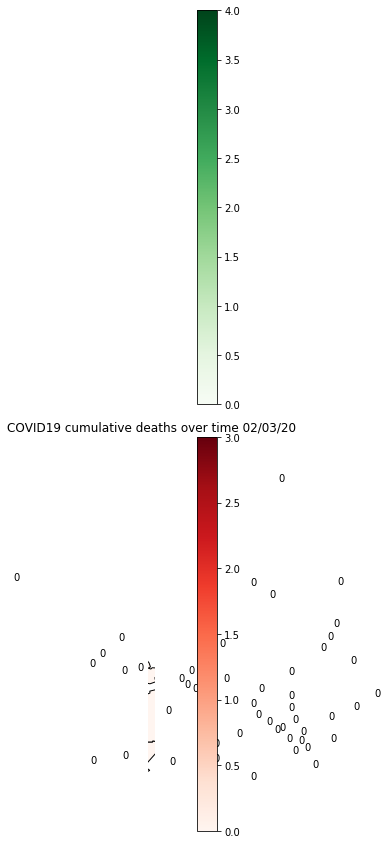

In [148]:
color_max_europe_spread=4  # 10000
color_max_europe_deaths=3   # 1000 

europe_spread = {
    'data' : conf,
    'color_min' : 0,
    'color_max' : color_max_europe_spread,
    'cmap' : 'Greens',
    'map_data' : europe,
    'feature': feature_spread,
    'title_annot' : title_spread
}

europe_death = {
    'data' : dead, 
    'color_min' : 0,
    'color_max' : color_max_europe_deaths,
    'cmap' : 'Reds',
    'map_data' : europe,
    'feature': feature_deaths,
    'title_annot' : title_deaths
}

plot_by_region(start_date='22/01/20',
               dims=FIG_DIMS_H,
               annot=True,
               verbose=False,
               params=[europe_spread, europe_death],
               mode='global',
               save_path='./europe/',
               dpi=FIG_DPI)